In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import functional as TF

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.nn.functional import interpolate

from tqdm import tqdm

from sklearn.metrics import jaccard_score

In [2]:
class RandomCropTransform:
    def __init__(self, output_size):
        """
        Initializes the random cropping transformation with a specified output size.

        Args:
            output_size (int): Side length of the output square for cropping.
        """
        self.output_size = output_size

    def __call__(self, image, mask):
        # Verificar que las dimensiones de la imagen y la máscara son mayores que el tamaño de salida deseado
        assert image.size[0] >= self.output_size and image.size[1] >= self.output_size
        
        white_threshold = 0.1  # Threshold for the maximum allowed white pixels in the crop
        max_attempts = 100  # Limit the number of attempts to find a suitable crop

        for _ in range(max_attempts):
            i = random.randint(0, image.size[0] - self.output_size)
            j = random.randint(0, image.size[1] - self.output_size)

            cropped_image = TF.crop(image, i, j, self.output_size, self.output_size)
            cropped_mask = TF.crop(mask, i, j, self.output_size, self.output_size)

            # Apply additional random transformations
            image_array = np.array(cropped_image)
            num_white_pixels = np.sum(np.all(image_array == [255, 255, 255], axis=-1))
            total_pixels = self.output_size * self.output_size
            if num_white_pixels / total_pixels < white_threshold:
                break  # Si el recorte cumple con el umbral, terminar el bucle
                
        # Apply additional random transformations
        if random.random() > 0.5:
            cropped_image, cropped_mask = TF.hflip(cropped_image), TF.hflip(cropped_mask)
        if random.random() > 0.5:
            cropped_image, cropped_mask = TF.vflip(cropped_image), TF.vflip(cropped_mask)
        if random.random() > 0.5:
            angle = 90
            cropped_image, cropped_mask = TF.rotate(cropped_image, angle), TF.rotate(cropped_mask, angle)

        return cropped_image, cropped_mask
    
class SatelliteBuildingDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        """
        Initializes the SatelliteBuildingDataset class with specific directories for images and masks,
        and with optional transformations that can be applied to both images and masks.

        Args:
            image_dir (string): Directory containing all images.
            mask_dir (string): Directory containing all masks.
            transform_image (callable, optional): Optional transformation function to apply to images.
            transform_mask (callable, optional): Optional transformation function to apply to masks.
        """
        # Assign to instance variables the values of the parameters
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        # List all files in the image directory. It is assumed that each image has its corresponding mask.
        self.images = os.listdir(image_dir)

    def __len__(self):
        # Returns the total number of images in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Build the full paths for the image and mask using the provided index
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])
        
        # Open the image and convert it to RGB color
        image = Image.open(img_name).convert("RGB")
        # Open the mask and convert it to grayscale so that it has a single channel
        mask = Image.open(mask_name).convert("L")  

        # Apply the specified transformations to the image and mask, if provided
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        # Return the processed image and mask
        return image, mask

class SatelliteDataset_onehot(Dataset):
    def __init__(self, image_dir, mask_dir, output_size, transform=None, resize=True):
        """
        Initializes the satellite dataset with capabilities to transform images and masks.

        Args:
            image_dir (str): Directory with images.
            mask_dir (str): Directory with masks.
            output_size (int): Side length of the output square for cropping.
            transform (callable, optional): Transformations to apply to the masks.
            resize (bool): Whether to apply cropping and resizing.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = [img for img in os.listdir(image_dir) if img.endswith('.png')]
        self.transform = transform
        self.crop_transform = RandomCropTransform(output_size)
        self.resize = resize
        self.output_size = output_size
        self.resize_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        # Si resize está activo, aplicar transformaciones de recorte y redimensionamiento
        if self.resize:
            image, mask = self.crop_transform(image, mask)
            image = self.resize_transform(image)
            mask = self.transform(mask)
        else:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [5]:
class ToOneHot:
    def __init__(self, n_classes=2):
        """
        Initializes a transformer that converts masks to one-hot representation.

        Args:
            n_classes (int): Number of distinct classes in the mask, including the background.
        """
        self.n_classes = n_classes

    def __call__(self, mask):
        """
        Applies the transformation to a mask.

        Args:
            mask (PIL Image or ndarray): Input mask.

        Returns:
            Tensor: Mask in one-hot format as a PyTorch tensor.
        """
        # Convertir la máscara a array de numpy y ajustar los valores a 0 o 1
        mask_array = np.array(mask)
        mask_array = np.where(mask_array == 255, 1, 0)  # Convertir 255 a 1, manteniendo 0 como está
        # Convertir la máscara ajustada a tensor
        mask_tensor = torch.as_tensor(mask_array, dtype=torch.int64)
        # Aplicar one_hot
        one_hot = torch.nn.functional.one_hot(mask_tensor, num_classes=self.n_classes).permute(2, 0, 1).float()
        return one_hot

def create_dataloaders_onehot(base_path, resize, batch_size=4):
    """
    Creates dataloaders for training and validation with specific transformations, including one-hot for the masks.

    Args:
        base_path (str): Base path where image and mask directories are located.
        resize (int): Size to which images and masks will be resized.
        batch_size (int): Number of elements in each data batch.

    Returns:
        tuple: Two DataLoaders, one for training and another for validation.
    """
    # Transformations for images
    transform_image = transforms.Compose([
        transforms.Resize(1344),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    transform_mask_train = transforms.Compose([
        transforms.Resize(resize),
        ToOneHot(),
        # transforms.ToTensor()
    ])

    transform_mask_val = transforms.Compose([
        transforms.Resize(1344),
        ToOneHot(),
        # transforms.ToTensor()
    ])
    
    # Data directories
    train_dir = os.path.join(base_path, 'train')
    train_mask_dir = os.path.join(base_path, 'train_labels')
    val_dir = os.path.join(base_path, 'val')
    val_mask_dir = os.path.join(base_path, 'val_labels')
    
    # Create datasets and dataloaders
    train_dataset = SatelliteDataset_onehot(train_dir, train_mask_dir, output_size=resize, transform=transform_mask_train, resize=True)
    val_dataset = SatelliteBuildingDataset(val_dir, val_mask_dir, transform_image, transform_mask_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Configuración inicial
base_path = os.getcwd()
base_path = os.path.join(base_path, 'BDS/png')

# Crear dataloaders para un tamaño de salida especificado
output_size = 224
train_loader, val_loader = create_dataloaders_onehot(base_path, output_size)

Image shape: torch.Size([3, 224, 224]) Mask shape: torch.Size([2, 224, 224])
Image shape: torch.Size([3, 224, 224]) Mask shape: torch.Size([2, 224, 224])
Image shape: torch.Size([3, 224, 224]) Mask shape: torch.Size([2, 224, 224])
Image shape: torch.Size([3, 224, 224]) Mask shape: torch.Size([2, 224, 224])


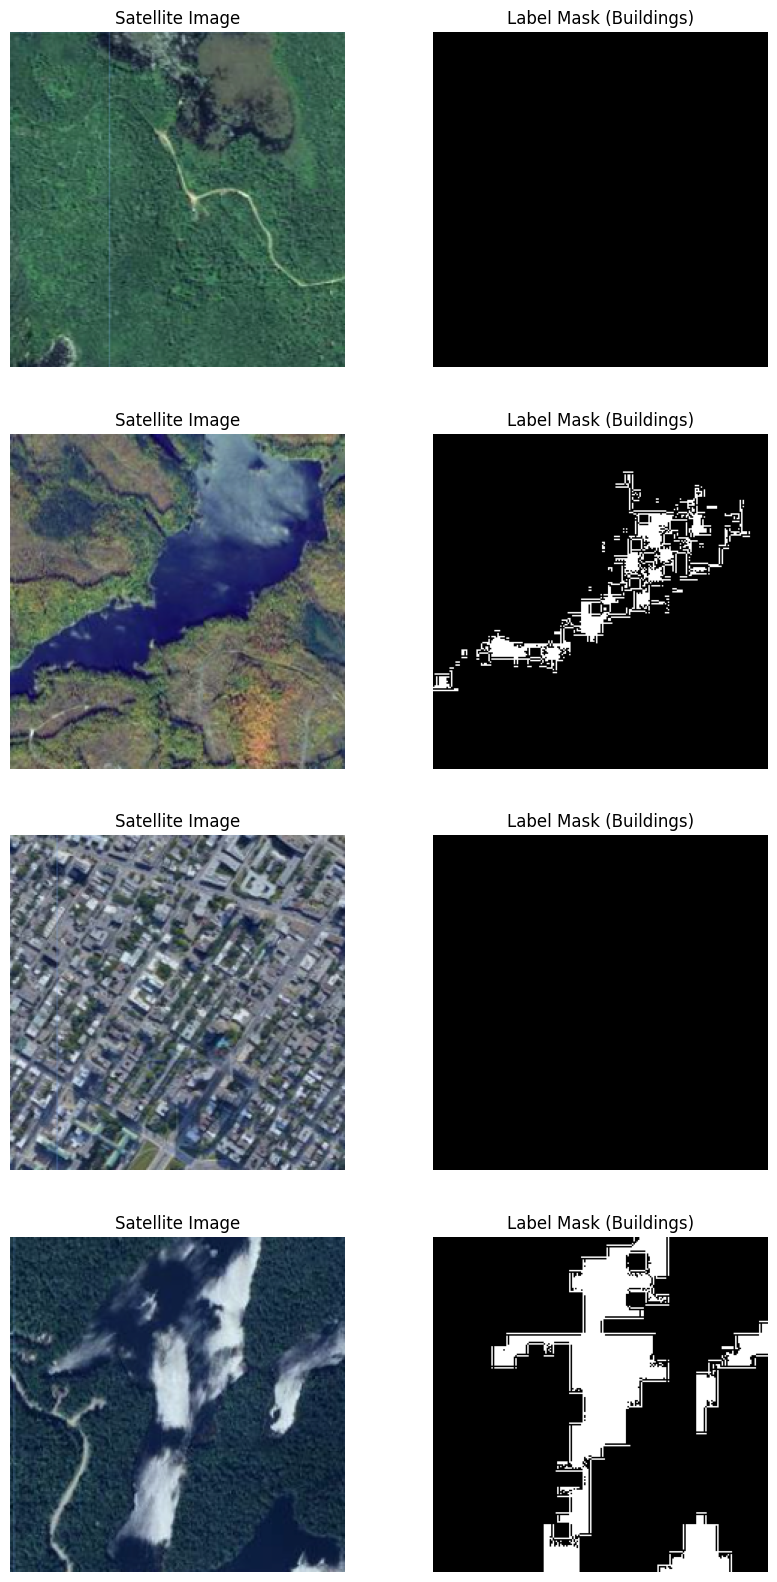

In [6]:
def show_images(images, masks, num_images=4):
    """
    Muestra un conjunto de imágenes y máscaras.

    Args:
        images (Tensor): Tensor de imágenes con dimensiones [batch_size, channels, height, width].
        masks (Tensor): Tensor de máscaras con dimensiones [batch_size, channels, height, width], 
                        donde cada canal representa una clase diferente.
        num_images (int): Número de imágenes y máscaras a mostrar.
    """
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    for i in range(num_images):
        # Reorganizar los canales de la imagen para la visualización
        img = images[i].permute(1, 2, 0)
        img = img.numpy()
        # Normalizar la imagen para mejorar la visualización
        img = (img - img.min()) / (img.max() - img.min())
        
        # Seleccionar el canal correspondiente a la clase de interés, por ejemplo, edificios
        mask = masks[i][1]  # Suponiendo que el segundo canal representa edificios
        mask = mask.numpy()

        # Imprimir dimensiones para verificar que todo está correcto
        print("Image shape:", images[i].shape, "Mask shape:", masks[i].shape)
        
        axs[i, 0].imshow(img)
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 0].set_title('Satellite Image')
        axs[i, 1].set_title('Label Mask (Buildings)')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
    plt.show()

# Suponiendo que `train_loader` ya está definido y cargado correctamente
images, masks = next(iter(train_loader))  # Cargar un lote de imágenes y máscaras del DataLoader
show_images(images, masks)  # Llamar a la función para mostrar las imágenes

In [7]:
# The Neural Network 
# We create the model, as well as the loss function. 
# The model is of the U-Net type, with 4 encoder downsampling blocks and 4 decoder upsampling blocks.

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Double convolution block that applies two convolution layers with a batch normalization 
        and ReLU activation between them.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        DownBlock in U-Net that includes a DoubleConv followed by max pooling 
        to reduce spatial dimension.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels after DoubleConv.
        """
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        """
        UpBlock in U-Net that performs upsampling and combines features
        from earlier layers through concatenation operation.

        Args:
            in_channels (int): Total number of input channels (sum of output channels from previous block and skip connection).
            out_channels (int): Number of output channels.
            up_sample_mode (str): Upsampling mode, 'conv_transpose' for ConvTranspose2d or 'bilinear' for bilinear interpolation.
        """
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        """
        Initializes the U-Net with a descending and ascending path, including a final block.

        Args:
            out_classes (int): Number of output classes for segmentation.
            up_sample_mode (str): Method for upsampling; either 'conv_transpose' or 'bilinear'.
        """
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Inicialización de los bloques de descenso
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Inicialización de los bloques de ascenso
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Capa convolucional final
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Defines the data flow through the network, using the defined blocks.

        Args:
            x (Tensor): Input image.

        Returns:
            Tensor: Network outputs with class probabilities.
        """
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        x = self.softmax(x)  # Aplicar softmax en la última capa
        return x

In [10]:
def split_image_into_segments(image_tensor, output_size):
    """
    Splits a large image into smaller segments.

    Args:
        image_tensor (Tensor): Input image.
        output_size (int): Size of each square segment.

    Returns:
        list: List of image segments.
        list: List of coordinates corresponding to each segment.
    """
    _, h, w = image_tensor.shape
    segments = []
    coords = []
    for i in range(0, h, output_size):
        for j in range(0, w, output_size):
            right = min(j + output_size, w)
            lower = min(i + output_size, h)
            segment = image_tensor[:, i:lower, j:right]
            segments.append(segment)
            coords.append((j, i))
    return segments, coords


def predict_and_recombine_segments(segments, coords, model, output_size, image_shape, device):
    """
    Predicts and recombines image segments to form the complete mask.

    Args:
        segments (list): Image segments.
        coords (list): Coordinates of each segment in the original image.
        model (UNet): U-Net model.
        output_size (int): Size of each segment.
        image_shape (tuple): Original dimensions of the image.
        device (torch.device): Device on which the model is running.

    Returns:
        Tensor: Complete reconstructed mask.
    """
    full_mask = torch.zeros((2, image_shape[1], image_shape[2]), device=device)
    for segment, (x, y) in zip(segments, coords):
        segment = segment.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(segment)
        full_mask[:, y:y+output_size, x:x+output_size] = output.squeeze(0)
    return full_mask



def calculate_iou(outputs, masks):
    """
    Calculates the Intersection over Union (IoU) by interpolating the outputs if necessary to match the size of the masks.

    Args:
        outputs (Tensor): Model output masks.
        masks (Tensor): True masks for comparison.

    Returns:
        float: Mean IoU score.
    """
    # Interpolar las salidas si es necesario para que coincidan con el tamaño de las máscaras
    if outputs.size()[2:] != masks.size()[2:]:
        outputs = F.interpolate(outputs, size=masks.size()[2:], mode='nearest')

    # Aplica sigmoid y luego umbraliza las salidas para convertirlas en binarias
    outputs = torch.sigmoid(outputs) > 0.5
    outputs = outputs.float()

    # Asegurarse de que ambos tensores están en CPU y convertidos a numpy uint8
    outputs = outputs.cpu().numpy().astype(np.uint8)
    masks = masks.cpu().numpy().astype(np.uint8)

    # Calcula IoU usando jaccard_score con zero_division ajustado
    ious = [jaccard_score(m.flatten(), o.flatten(), zero_division=1) for m, o in zip(masks, outputs)]
    return np.mean(ious)


def validate_model(val_loader, model, output_size, device, criterion):
    """
    Evaluates the model on a validation dataset.

    Args:
        val_loader (DataLoader): DataLoader that provides batches of images and masks.
        model (nn.Module): Neural network model to evaluate.
        output_size (int): Size of the segments into which each image is divided.
        device (torch.device): Device where computations are performed (CPU or GPU).
        criterion (loss function): Loss function used to evaluate model accuracy.

    Returns:
        tuple: Average validation losses and average IoU scores.
    """
    model.eval()  # Pone el modelo en modo de evaluación (importante para desactivar dropout, batchnorm, etc.)
    val_losses = []  # Lista para almacenar las pérdidas de cada lote
    iou_scores = []  # Lista para almacenar los puntajes IoU de cada lote

    for images, masks in val_loader:
        images = images.to(device)  # Envía las imágenes al dispositivo adecuado
        masks = masks.to(device)  # Envía las máscaras al dispositivo adecuado

        # Tensor para almacenar las predicciones de todas las imágenes en el lote
        predictions = torch.zeros(masks.size(0), 2, masks.size(2), masks.size(3), device=device)

        # Procesar cada imagen del lote individualmente
        for i, image in enumerate(images):
            # Dividir la imagen en segmentos y obtener las coordenadas de cada segmento
            segments, coords = split_image_into_segments(image.cpu(), output_size)
            # Predecir y reconstruir la máscara completa a partir de los segmentos
            full_mask = predict_and_recombine_segments(segments, coords, model, output_size, image.shape, device)
            predictions[i] = full_mask.to(device)  # Guardar la máscara reconstruida en el tensor de predicciones
        
        # Calcular la pérdida para el lote utilizando la función de pérdida especificada
        loss = criterion(predictions, masks.argmax(dim=1))  # Usar argmax si las máscaras están en formato one-hot
        val_losses.append(loss.item())  # Agregar la pérdida del lote a la lista de pérdidas

        # Calcular el IoU para el lote utilizando la función definida
        iou = calculate_iou(predictions.argmax(dim=1), masks.argmax(dim=1))  # Usar argmax para comparar las clases predichas
        iou_scores.append(iou)  # Agregar el IoU del lote a la lista de IoUs
        
    # Calcular y devolver el promedio de las pérdidas y los IoUs de todos los lotes procesados
    return np.mean(val_losses), np.mean(iou_scores)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

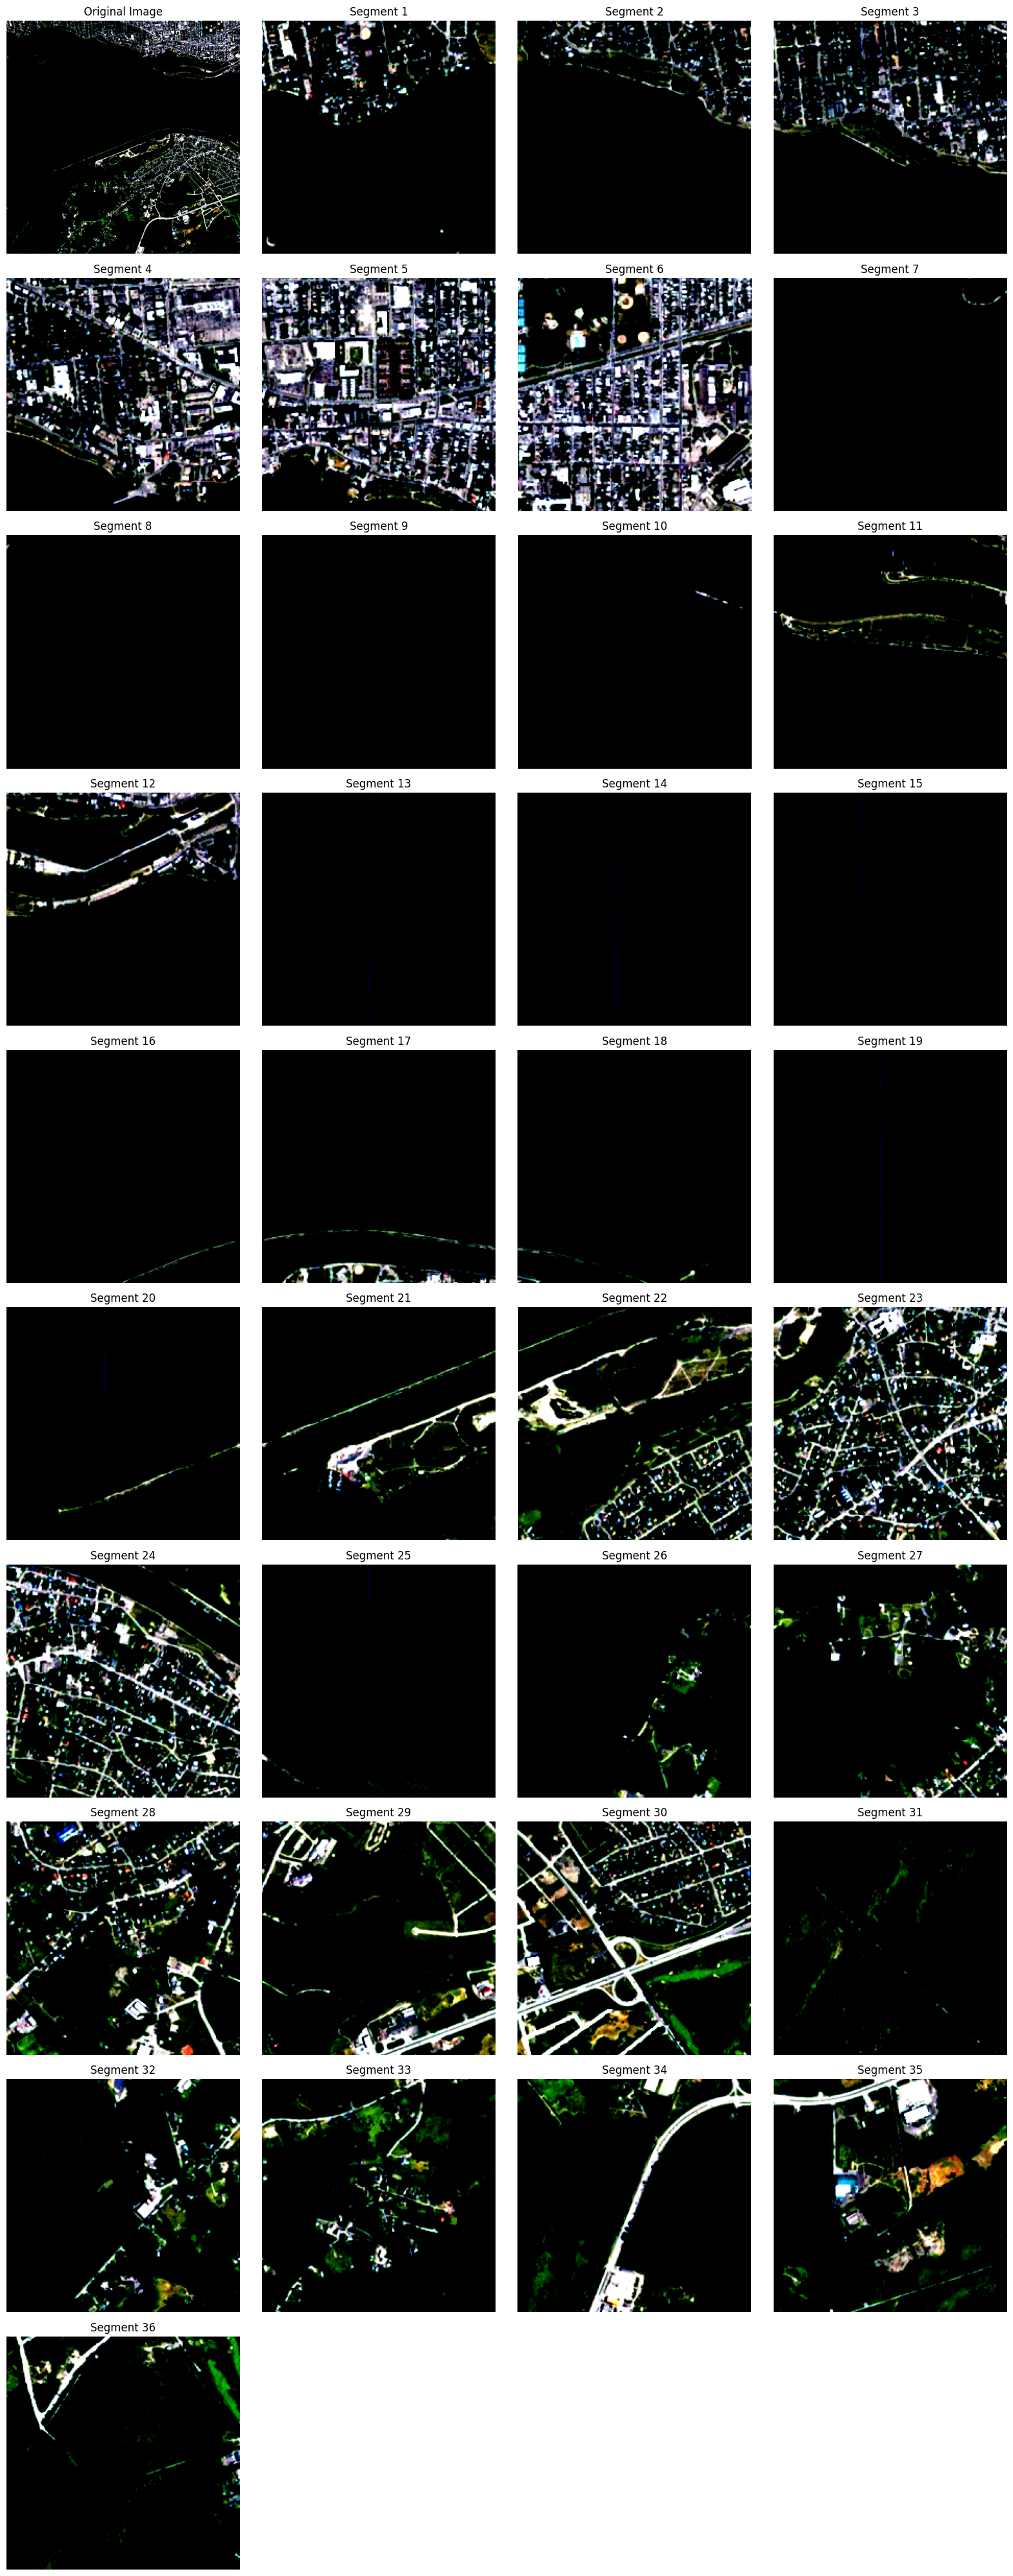

In [11]:
def visualize_image_and_segments(data_loader, output_size):
    """
    Visualizes the first image from a DataLoader and its resulting segments of a specified size.

    Args:
        data_loader (DataLoader): DataLoader that provides images and masks.
        output_size (int): Size of the square segments into which the image will be divided.
    """
    # Obtener un batch de imágenes y máscaras
    images, masks = next(iter(data_loader))
    image = images[0]  # Tomar la primera imagen del batch
    mask = masks[0]    # Tomar la primera máscara del batch

    # Dividir la imagen en segmentos utilizando la función definida
    segments, coords = split_image_into_segments(image, output_size)

    # Configuración para plotear
    num_segments = len(segments)
    cols = 4  # Número de columnas en el plot
    rows = (num_segments // cols) + 2  # Calcular número de filas en el plot

    plt.figure(figsize=(cols * 4, rows * 4))

    # Mostrar la imagen original en el primer subplot
    plt.subplot(rows, cols, 1)
    plt.imshow(image.permute(1, 2, 0))  # Reordenar de [C, H, W] a [H, W, C]
    plt.title("Original Image")
    plt.axis('off')

    # Mostrar cada segmento en subplots adicionales
    for idx, segment in enumerate(segments, start=2):
        plt.subplot(rows, cols, idx)
        plt.imshow(segment.permute(1, 2, 0))  # Reordenar de [C, H, W] a [H, W, C]
        plt.title(f"Segment {idx-1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Suponer que `val_loader` y `output_size` están correctamente definidos
visualize_image_and_segments(val_loader, output_size=224)

In [12]:
# Load the model
model = UNet()
# Verifica si CUDA está disponible y mueve el modelo al dispositivo apropiado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def weight_reset(m):
    """
    Reinicia los pesos de las capas convolucionales y lineales a sus valores iniciales.

    Args:
        m: Módulo de PyTorch (capa).
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [13]:
sizes = [(224, 224), ]
num_epochs = 50
# Suponiendo que estás ejecutando esto desde el directorio principal de tu proyecto
base_path = os.getcwd()  # Obtener la ruta del directorio actual donde se ejecuta el script
base_path = os.path.join(base_path, 'BDS/png')  # Añadir subdirectorio 'images' a la ruta base

best_loss = 0  # Inicialización de la mejor pérdida como cero para comparaciones futuras

torch.cuda.empty_cache()  # Limpiar la caché de CUDA para liberar memoria del GPU

for resize in sizes:
    print(f"Training model with image size: {resize}")  # Informar sobre el tamaño de imagen con el que se va a entrenar
    train_loader, val_loader = create_dataloaders_onehot(base_path, resize[0])  # Crear DataLoader para entrenamiento y validación

    # Reajustar listas de pérdidas e IoU para cada tamaño
    train_losses = []
    val_losses = []
    iou_scores = []

    for epoch in range(num_epochs):  # Bucle sobre cada época
        model.train()  # Poner el modelo en modo entrenamiento
        running_loss = 0.0
        train_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=True)  # Usar tqdm para la barra de progreso
        for images, masks in train_tqdm:
            images, masks = images.to(device), masks.to(device)  # Mover imágenes y máscaras al dispositivo (GPU o CPU)
            
            optimizer.zero_grad()  # Resetear los gradientes del optimizador
            outputs = model(images)  # Obtener las salidas del modelo
            loss = criterion(outputs, masks)  # Calcular la pérdida
            loss.backward()  # Retropropagación de la pérdida
            optimizer.step()  # Actualizar los pesos del modelo
            
            running_loss += loss.item() * images.size(0)  # Acumular la pérdida ajustada por el tamaño del batch
            train_tqdm.set_postfix(loss=(running_loss / (train_tqdm.last_print_n + 1)))  # Mostrar la pérdida promedio en tqdm
        
        epoch_loss = running_loss / len(train_loader.dataset)  # Calcular la pérdida promedio de la época
        train_losses.append(epoch_loss)  # Guardar la pérdida de entrenamiento

        val_loss, average_iou = validate_model(val_loader, model, output_size=1344, device=device, criterion=criterion)  # Validar el modelo
        val_losses.append(val_loss)  # Guardar la pérdida de validación
        iou_scores.append(average_iou)  # Guardar el IoU promedio
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Average IoU: {iou_scores[-1]:.4f}')

        if average_iou > best_loss:  # Guardar el modelo si el IoU promedio es el mejor hasta ahora
            model_save_path = os.path.join('saved_models', f'model_cropped_{resize[0]}x{resize[1]}.pth')
            os.makedirs('saved_models', exist_ok=True)  # Crear el directorio si no existe
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
            best_loss = average_iou

    # Opcionalmente, graficar los resultados para cada tamaño
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Losses over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_scores, label='IoU Score')
    plt.title(f'IoU Scores over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.show()

    model.apply(weight_reset)  # Reiniciar los pesos del modelo para evitar el efecto de entrenamiento residual en la próxima iteración

Training model with image size: (224, 224)


Epoch 1/50 Training:   0%|          | 0/20 [00:00<?, ?it/s]d:\Development\Anaconda3\envs\coen6331\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/50 Training: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s, loss=2.42]


: 

In [ ]:
def create_test_dataloader(base_path, batch_size, resize):
    """
    Crea un DataLoader para el conjunto de datos de prueba con transformaciones específicas para imágenes y máscaras.
    
    Args:
        base_path (str): Ruta base donde están almacenados los directorios de imágenes y máscaras.
        batch_size (int): Número de muestras por cada lote.
        resize (int): Tamaño al que se redimensionarán las imágenes y las máscaras.
    
    Returns:
        DataLoader: Objeto DataLoader configurado para el conjunto de datos de prueba.
    """
    # Transformaciones para las imágenes
    transform_image = transforms.Compose([
        transforms.Resize(1344),  # Redimensionar las imágenes a un tamaño fijo
        transforms.ToTensor(),  # Convertir las imágenes a tensores
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar las imágenes
    ])
    
    # Transformaciones para las máscaras, incluyendo conversión a formato one-hot
    transform_mask = transforms.Compose([
        transforms.Resize(1344),  # Redimensionar las máscaras al mismo tamaño que las imágenes
        ToOneHot(),  # Convertir las máscaras a formato one-hot
        # Nota: La conversión a Tensor se maneja internamente por ToOneHot si es necesario
    ])
    
    # Directorios donde se encuentran las imágenes y máscaras de prueba
    test_dir = os.path.join(base_path, 'test')
    test_mask_dir = os.path.join(base_path, 'test_labels')
    # Crear un conjunto de datos utilizando las transformaciones definidas
    test_dataset = SatelliteBuildingDataset(test_dir, test_mask_dir, transform_image, transform_mask)
    # Crear el DataLoader con los datos de prueba
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_loader


def test_and_plot_model(val_loader, model, output_size, device, num_examples=1):
    """
    Evalúa el modelo y visualiza los resultados para un conjunto limitado de ejemplos del DataLoader de validación.
    
    Args:
        val_loader (DataLoader): DataLoader que proporciona los datos de prueba o validación.
        model (torch.nn.Module): Modelo de red neuronal a evaluar.
        output_size (int): Tamaño de salida deseado para los segmentos de las imágenes.
        device (torch.device): Dispositivo en el que se ejecuta el modelo (CPU o GPU).
        num_examples (int): Número de ejemplos a visualizar.
    """
    model.eval()  # Poner el modelo en modo evaluación
    for batch_idx, (images, masks) in enumerate(val_loader):
        if batch_idx >= num_examples:
            break
        images = images.to(device)
        masks = masks.to(device)
        predictions = torch.zeros_like(masks)  # Preparar tensor para almacenar las predicciones

        for i, (image, mask) in enumerate(zip(images, masks)):
            segments, coords = split_image_into_segments(image.cpu(), output_size)
            full_mask = predict_and_recombine_segments(segments, coords, model, output_size, image.shape, device)
            predictions[i] = full_mask.to(device)
        
            # Convertir máscaras one-hot a un canal para la visualización
            mask_single_channel = torch.argmax(mask, dim=0).cpu()
            full_mask_single_channel = torch.argmax(full_mask, dim=0).cpu()
        
            # Configurar los plots para mostrar la imagen original, la máscara original y la máscara predicha
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image.cpu().permute(1, 2, 0))
            plt.title("Original Image")
            plt.axis("off")
        
            plt.subplot(1, 3, 2)
            plt.imshow(mask_single_channel, cmap="gray")
            plt.title("Original Mask")
            plt.axis("off")
        
            plt.subplot(1, 3, 3)
            plt.imshow(full_mask_single_channel, cmap="gray")
            plt.title("Predicted Full Mask")
            plt.axis("off")
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


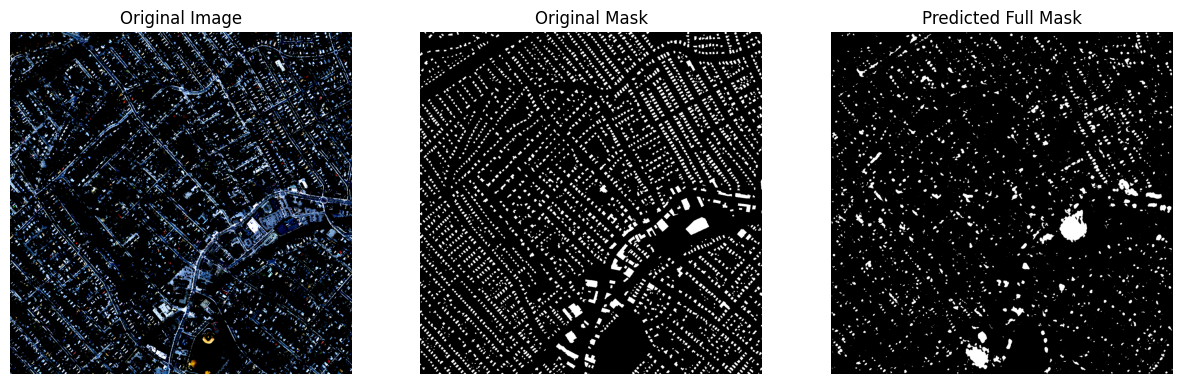

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


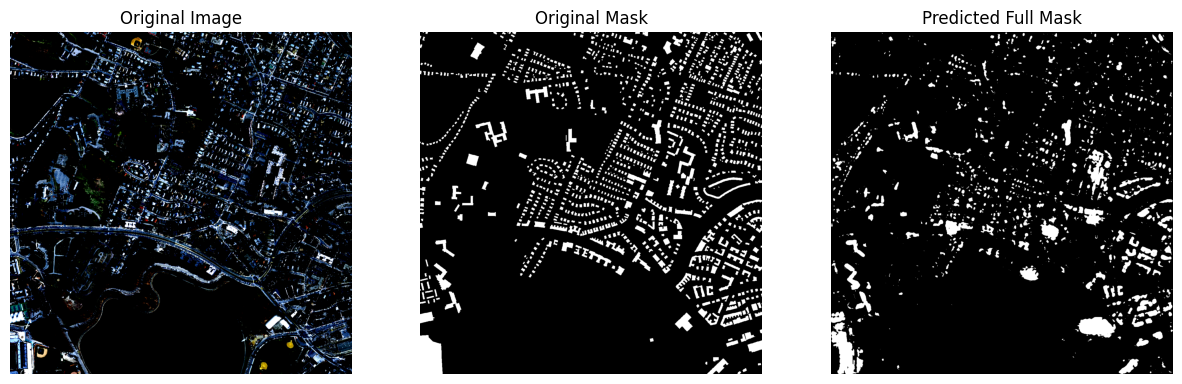

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


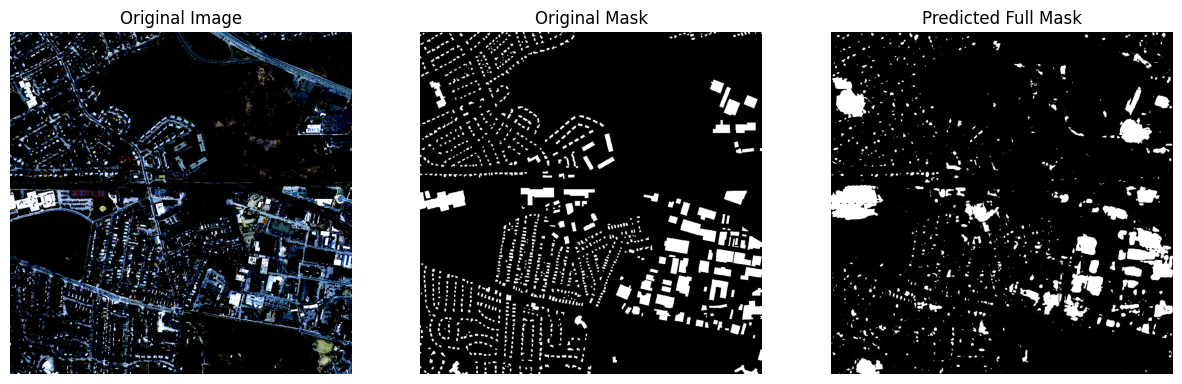

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


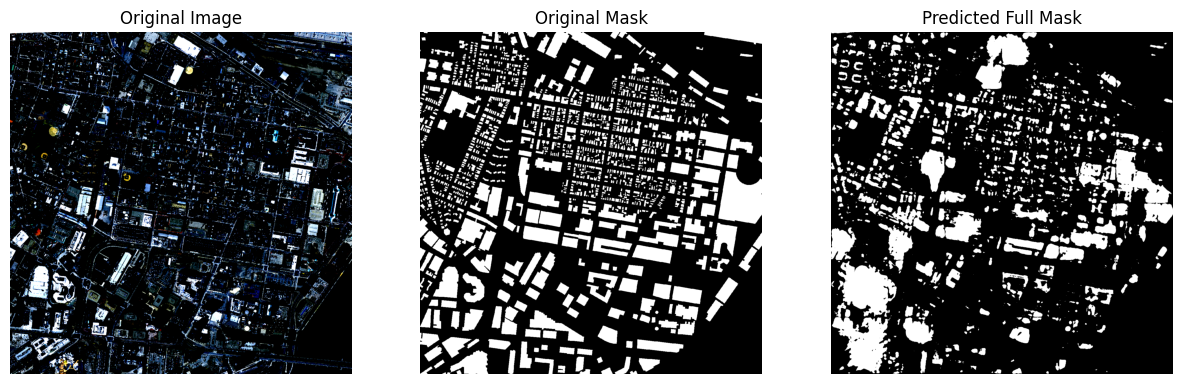

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


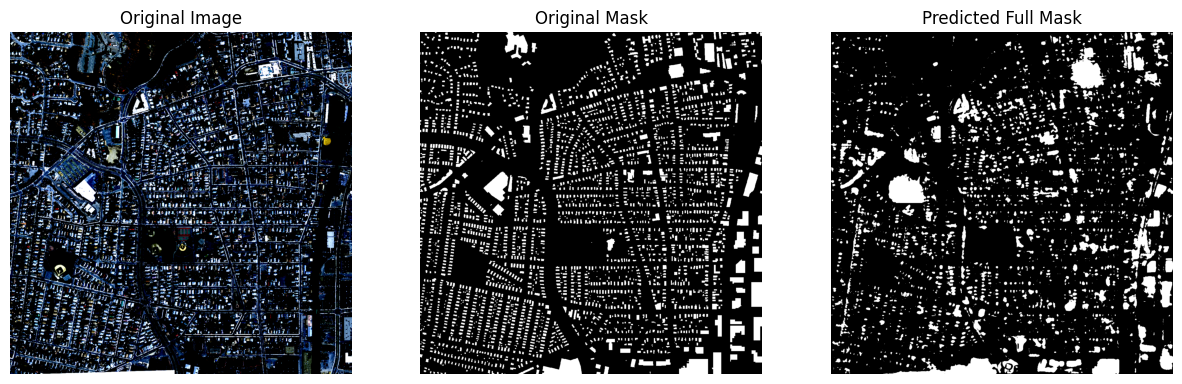

In [ ]:
batch_size = 1  # Tamaño del lote establecido a 1, útil para evaluaciones detalladas o donde se necesite procesamiento individual
current_directory = os.getcwd()
base_path = os.path.join(current_directory, 'BDS/png')

# Bucle sobre diferentes tamaños de imagen para probar el modelo con cada configuración de tamaño
for resize in sizes:
    model_path = f'saved_models/model_cropped_{resize[0]}x{resize[1]}.pth'  # Ruta al modelo guardado
    test_loader = create_test_dataloader(base_path, batch_size, resize)  # Crear DataLoader para el conjunto de prueba

    model = UNet()  # Creación de la instancia del modelo, asumiendo que es una U-Net
    model.load_state_dict(torch.load(model_path))  # Cargar los pesos del modelo desde el archivo guardado
    model.to(device)  # Mover el modelo al dispositivo adecuado (GPU o CPU)

    # Ejecutar la función que prueba el modelo y visualiza los resultados
    # Nota: Asegúrate de que 'output_size' esté definido correctamente aquí para que coincida con la lógica de 'test_and_plot_model'
    test_and_plot_model(test_loader, model, output_size, device, num_examples=5)
    